In [1]:
# 토큰화 & 형태소 분석 모듈 ----------------------------------
from konlpy.tag import Okt
from collections import Counter

# 파이토치 모듈 ----------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torchmetrics.classification import MulticlassF1Score
import torch.optim.lr_scheduler as lr_scheduler
from torchmetrics.classification import BinaryAccuracy

# 데이터 전처리 & 로드 모듈 -----------------------------------
import re
import os
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

# 개인 정리 모듈 
from RNN_utils import *

In [2]:
reviewDF = pd.read_csv('./Movie_total.csv', encoding='utf-8-sig')

reviewDF.head(5)

,review,rating,label
0,"시종일관 강약없는 비장은 실소를 유발\n 박영태님, 신윤수님과 함께.",2.0,0
1,최민식이 이순신으로 나와서 일본사람 잡는데 대한민국사람이라면 감동해야지?? 라고 강...,1.0,0
2,어쨌든 해전 부분은 인상적.,2.5,0
3,"칼의 노래도 아니고,\n300도 아니고.\n뻔한 연출에 과한 연극.\n성웅을 그린다...",1.5,0
4,감독이나 관객이나 영화를 보지않고 역사만을 보고 카타르시스를 느끼고있다니,1.0,0


In [3]:
# 정규식 처리
reviewDF['cleaned'] = reviewDF['review'].apply(cleantext)

In [4]:
reviewDF.head(5)

,review,rating,label,cleaned
0,"시종일관 강약없는 비장은 실소를 유발\n 박영태님, 신윤수님과 함께.",2.0,0,시종일관 강약없는 비장은 실소를 유발\n 박영태님 신윤수님과 함께
1,최민식이 이순신으로 나와서 일본사람 잡는데 대한민국사람이라면 감동해야지?? 라고 강...,1.0,0,최민식이 이순신으로 나와서 일본사람 잡는데 대한민국사람이라면 감동해야지 라고 강요하...
2,어쨌든 해전 부분은 인상적.,2.5,0,어쨌든 해전 부분은 인상적
3,"칼의 노래도 아니고,\n300도 아니고.\n뻔한 연출에 과한 연극.\n성웅을 그린다...",1.5,0,칼의 노래도 아니고\n도 아니고\n뻔한 연출에 과한 연극\n성웅을 그린다고 성역에 ...
4,감독이나 관객이나 영화를 보지않고 역사만을 보고 카타르시스를 느끼고있다니,1.0,0,감독이나 관객이나 영화를 보지않고 역사만을 보고 카타르시스를 느끼고있다니


In [5]:
reviewDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28442 entries, 0 to 28441
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   review   28442 non-null  object 
 1   rating   28442 non-null  float64
 2   label    28442 non-null  int64  
 3   cleaned  28442 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 888.9+ KB


In [6]:
train = reviewDF.sample(frac=0.8, random_state=12)
valid = reviewDF.drop(train.index)

# 확인
print(f"Train Data Size: {len(train)}")
print(f"Valid Data Size: {len(valid)}")

Train Data Size: 22754
Valid Data Size: 5688


In [7]:
# 불용어 처리 데이터 로드
STOP_FILE = './kor_stopwordsVer2.txt'

kor_stopwords = clean_korStopwords(STOP_FILE)
kor_stopwords.append('.')
kor_stopwords.append('\n')
kor_stopwords.append('\n ')
kor_stopwords.append('영화')
kor_stopwords.append('은')
kor_stopwords.append('는')
kor_stopwords.append('유아인')
kor_stopwords.append('류승완')
kor_stopwords.append('황정민')
kor_stopwords.append('이순신')

len(kor_stopwords)

608

In [8]:
# 토크나이저 인스턴스 생성
tokenizer = Okt()

# 토큰화
train_tokens = [
    [token for token in tokenizer.morphs(article) if token not in kor_stopwords] for article in train.cleaned
]

valid_tokens = [
    [token for token in tokenizer.morphs(article) if token not in kor_stopwords] for article in valid.cleaned
]

vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>","<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)}
it_to_token = {idx: token for idx, token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '한', '도', '적', '연기', '잘', '다', '수', '하는']
5002


In [9]:
# 단어 사전 저장
import pickle
with open('./vocab.pkl', 'wb') as f:
	pickle.dump(token_to_id, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.


(array([2.2478e+04, 1.8700e+02, 4.2000e+01, 2.6000e+01, 1.1000e+01,
        3.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0.   , 119.375, 238.75 , 358.125, 477.5  , 596.875, 716.25 ,
        835.625, 955.   ]),
 <BarContainer object of 8 artists>)

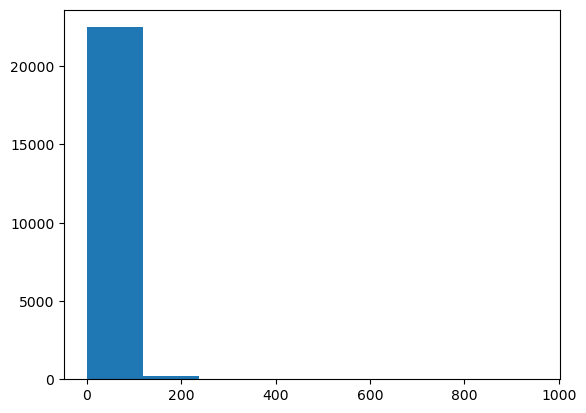

In [10]:
# 패딩 적정 길이 찾기
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen, bins=8)

(array([19461.,  2279.,   438.,   207.,   105.,    80.,    41.,    22.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <BarContainer object of 8 artists>)

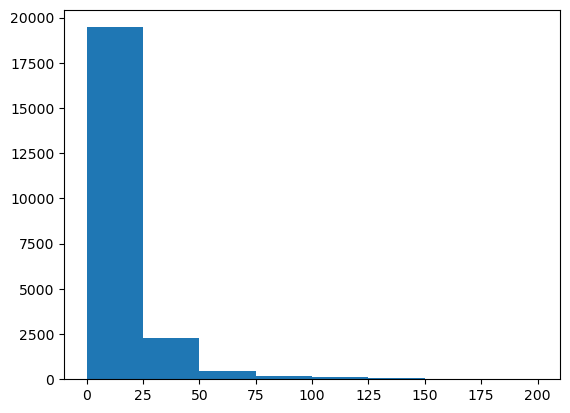

In [11]:
datalen = [len(tokens) for tokens in train_tokens]
datalen_100 = [len(tokens) for tokens in train_tokens if len(tokens) <= 200 ]
plt.hist(datalen_100, bins=8)

(array([4981., 6982., 3744., 2192., 1562., 1090.,  469.,  312.,  247.,
         187.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

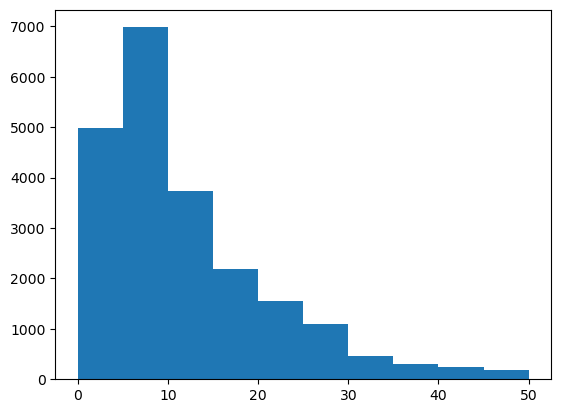

In [12]:
datalen = [len(tokens) for tokens in train_tokens]
datalen_100 = [len(tokens) for tokens in train_tokens if len(tokens) <= 50 ]
plt.hist(datalen_100, bins=10)

In [13]:
all_tokens = [token for tokens in train_tokens for token in tokens]
token_counts = Counter(all_tokens)
frequencies = list(token_counts.values())

# token_counts.most_common(80)

In [14]:
# 정수 인코딩 & 패딩
unk_id = token_to_id["<unk>"]

train_ids = [
	[token_to_id.get(token, unk_id) for token in review] for review in train_tokens
]

valid_ids = [
	[token_to_id.get(token, unk_id) for token in review] for review in valid_tokens
]

max_length = 25
pad_id = token_to_id["<pad>"]
train_ids = pad_sequences(train_ids, max_length, pad_id)
valid_ids = pad_sequences(valid_ids, max_length, pad_id)

print(train_ids[0])
print(valid_ids[0])

[ 1  1 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]
[ 124  839    1    1  198   22  286   71 2616  125  638 4277    2    1
   76 2299   71    3 2582    0    0    0    0    0    0]


In [15]:
# 데이터 로더 적용
train_ids = torch.tensor(train_ids)
valid_ids = torch.tensor(valid_ids)

train_labels = torch.tensor(train.label.values, dtype=torch.float32)
valid_labels = torch.tensor(valid.label.values, dtype=torch.float32)

train_DS = TensorDataset(train_ids, train_labels)
valid_DS = TensorDataset(valid_ids, valid_labels)

train_loader = DataLoader(train_DS, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_DS, batch_size=1, shuffle=False)

In [16]:
reviewDF['label'].value_counts()[0] / reviewDF['label'].value_counts()[1]

1.233021904687132

In [17]:
# 모델 파라미터 정의
n_vocab = len(token_to_id)
hidden_dim = 8
embedding_dim = 128
n_layers = 1
model_type = "lstm"

pos_weight = torch.FloatTensor([reviewDF['label'].value_counts()[0] / reviewDF['label'].value_counts()[1]])

device = "cuda" if torch.cuda.is_available() else "cpu"

classifier = SentenceClassifier(
    n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers
).to(device)

lossFunc = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
# optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-5	)
scoreFunc = BinaryAccuracy().to(device)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True) # score 사용 시

c:\Users\KDP-43\anaconda3\envs\TEXT_018_230_38\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\KDP-43\anaconda3\envs\TEXT_018_230_38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


----------
Epoch 1/20
----------
Epoch 1/20
Train Loss: 0.7670 | Train Acc: 0.5060
Valid Loss: 0.7641 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 2/20
----------
Epoch 2/20
Train Loss: 0.7646 | Train Acc: 0.5047
Valid Loss: 0.7635 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 1 scheduler.patience => 5
----------
Epoch 3/20
----------
Epoch 3/20
Train Loss: 0.7622 | Train Acc: 0.5172
Valid Loss: 0.7627 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 2 scheduler.patience => 5
----------
Epoch 4/20
----------
Epoch 4/20
Train Loss: 0.7513 | Train Acc: 0.5502
Valid Loss: 0.7369 | Valid Acc: 0.5682
scheduler.num_bad_epochs => 3 scheduler.patience => 5
----------
Epoch 5/20
----------
Epoch 5/20
Train Loss: 0.7084 | Train Acc: 0.6449
Valid Loss: 0.7318 | Valid Acc: 0.6227
scheduler.num_bad_epochs => 4 scheduler.patience => 5
----------
Epoch 6/20
----------
Epoch 6/20
Train Loss: 0.6582 | Train Acc: 0.6998
Valid Loss: 0.7283 | Valid Acc: 0.639

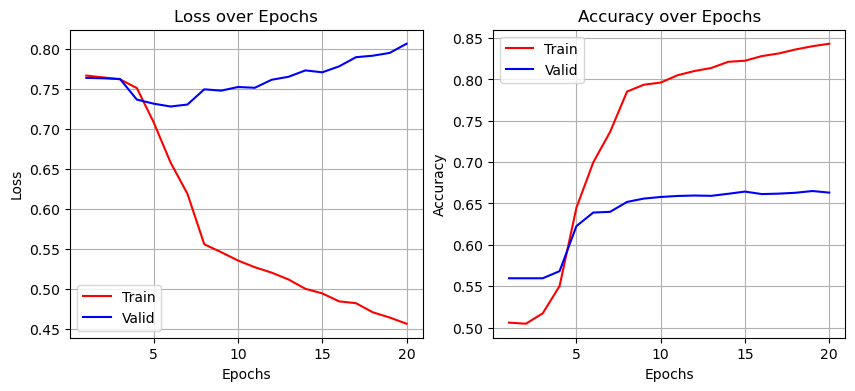

In [18]:
trainval_Binary(classifier, train_loader, valid_loader, lossFunc, scoreFunc, optimizer, device, scheduler, num_epochs=20)

- hidden_dim  (64=>32): 모델 학습 시간: 20분 40초

* LSTM, hidd_dim=32, max_length = 25
----------
Epoch 1/20
----------
Epoch 1/20
Train Loss: 0.7668 | Train Acc: 0.4916
Valid Loss: 0.7643 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 2/20
----------
Epoch 2/20
Train Loss: 0.7660 | Train Acc: 0.5026
Valid Loss: 0.7646 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 3/20
----------
Epoch 3/20
Train Loss: 0.7660 | Train Acc: 0.4891
Valid Loss: 0.7641 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 1 scheduler.patience => 5
----------
Epoch 4/20
----------
Epoch 4/20
Train Loss: 0.7624 | Train Acc: 0.5173
Valid Loss: 0.7547 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 2 scheduler.patience => 5
----------
Epoch 5/20
----------
Epoch 5/20
Train Loss: 0.7429 | Train Acc: 0.5658
Valid Loss: 0.7438 | Valid Acc: 0.5654
scheduler.num_bad_epochs => 3 scheduler.patience => 5
----------
Epoch 6/20
----------
Epoch 6/20
Train Loss: 0.7089 | Train Acc: 0.6167
Valid Loss: 0.7391 | Valid Acc: 0.5786
scheduler.num_bad_epochs => 4 scheduler.patience => 5
----------
Epoch 7/20
----------
Epoch 7/20
Train Loss: 0.6727 | Train Acc: 0.6520
Valid Loss: 0.7502 | Valid Acc: 0.6011
scheduler.num_bad_epochs => 5 scheduler.patience => 5
----------
Epoch 8/20
----------
Epoch 8/20
Train Loss: 0.6358 | Train Acc: 0.6829
Valid Loss: 0.7714 | Valid Acc: 0.6143
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 9/20
----------
Epoch 9/20
Train Loss: 0.5948 | Train Acc: 0.7084
Valid Loss: 0.7912 | Valid Acc: 0.6166
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 10/20
----------
Epoch 10/20
Train Loss: 0.5523 | Train Acc: 0.7341
Valid Loss: 0.7965 | Valid Acc: 0.6241
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 11/20
----------
Epoch 11/20
Train Loss: 0.5108 | Train Acc: 0.7616
Valid Loss: 0.8577 | Valid Acc: 0.6384
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 12/20
----------
Epoch 12/20
Train Loss: 0.4662 | Train Acc: 0.8017
Valid Loss: 0.8343 | Valid Acc: 0.6363
scheduler.num_bad_epochs => 1 scheduler.patience => 5
----------
Epoch 13/20
----------
Epoch 13/20
Train Loss: 0.4252 | Train Acc: 0.8280
Valid Loss: 0.9752 | Valid Acc: 0.6477
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 14/20
----------
Epoch 14/20
Train Loss: 0.3838 | Train Acc: 0.8517
Valid Loss: 1.0027 | Valid Acc: 0.6431
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 15/20
----------
Epoch 15/20
Train Loss: 0.3427 | Train Acc: 0.8758
Valid Loss: 1.0047 | Valid Acc: 0.6479
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 16/20
----------
Epoch 16/20
Train Loss: 0.3282 | Train Acc: 0.8843
Valid Loss: 1.0504 | Valid Acc: 0.6632
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 17/20
----------
Epoch 17/20
Train Loss: 0.2983 | Train Acc: 0.8995
Valid Loss: 1.1370 | Valid Acc: 0.6551
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 18/20
----------
Epoch 18/20
Train Loss: 0.2765 | Train Acc: 0.9075
Valid Loss: 1.1910 | Valid Acc: 0.6616
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 19/20
----------
Epoch 19/20
Train Loss: 0.2571 | Train Acc: 0.9135
Valid Loss: 1.1943 | Valid Acc: 0.6628
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 20/20
----------
Epoch 20/20
Train Loss: 0.2397 | Train Acc: 0.9211
Valid Loss: 1.2308 | Valid Acc: 0.6672
scheduler.num_bad_epochs => 0 scheduler.patience => 5
모델 학습 시간: 15분 29초


* GRU, hidd_dim = 32
<br></br>
----------
Epoch 1/20
----------
Epoch 1/20
Train Loss: 0.7664 | Train Acc: 0.4884
Valid Loss: 0.7643 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 2/20
----------
Epoch 2/20
Train Loss: 0.7659 | Train Acc: 0.4974
Valid Loss: 0.7645 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 3/20
----------
Epoch 3/20
Train Loss: 0.7661 | Train Acc: 0.4986
Valid Loss: 0.7650 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 4/20
----------
Epoch 4/20
Train Loss: 0.7655 | Train Acc: 0.5043
Valid Loss: 0.7647 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 1 scheduler.patience => 5
----------
Epoch 5/20
----------
Epoch 5/20
Train Loss: 0.7651 | Train Acc: 0.4980
Valid Loss: 0.7643 | Valid Acc: 0.5596
scheduler.num_bad_epochs => 2 scheduler.patience => 5
----------
Epoch 6/20
----------
Epoch 6/20
Train Loss: 0.7613 | Train Acc: 0.5030
Valid Loss: 0.7655 | Valid Acc: 0.5584
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 7/20
----------
Epoch 7/20
Train Loss: 0.7536 | Train Acc: 0.5128
Valid Loss: 0.7743 | Valid Acc: 0.5540
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 8/20
----------
Epoch 8/20
Train Loss: 0.7452 | Train Acc: 0.5225
Valid Loss: 0.7773 | Valid Acc: 0.5550
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 9/20
----------
Epoch 9/20
Train Loss: 0.7348 | Train Acc: 0.5335
Valid Loss: 0.7891 | Valid Acc: 0.5577
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 10/20
----------
Epoch 10/20
Train Loss: 0.7237 | Train Acc: 0.5391
Valid Loss: 0.8045 | Valid Acc: 0.5636
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 11/20
----------
Epoch 11/20
Train Loss: 0.7134 | Train Acc: 0.5446
Valid Loss: 0.8235 | Valid Acc: 0.5622
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 12/20
----------
Epoch 12/20
Train Loss: 0.7036 | Train Acc: 0.5603
Valid Loss: 0.8368 | Valid Acc: 0.5631
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 13/20
----------
Epoch 13/20
Train Loss: 0.6897 | Train Acc: 0.5883
Valid Loss: 0.8518 | Valid Acc: 0.5675
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 14/20
----------
Epoch 14/20
Train Loss: 0.6565 | Train Acc: 0.6483
Valid Loss: 0.8951 | Valid Acc: 0.5830
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 15/20
----------
Epoch 15/20
Train Loss: 0.6104 | Train Acc: 0.7083
Valid Loss: 0.8990 | Valid Acc: 0.5879
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 16/20
----------
Epoch 16/20
Train Loss: 0.5480 | Train Acc: 0.7595
Valid Loss: 0.9591 | Valid Acc: 0.5993
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 17/20
----------
Epoch 17/20
Train Loss: 0.4905 | Train Acc: 0.8031
Valid Loss: 0.9703 | Valid Acc: 0.6115
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 18/20
----------
Epoch 18/20
Train Loss: 0.4366 | Train Acc: 0.8285
Valid Loss: 0.9930 | Valid Acc: 0.6264
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 19/20
----------
Epoch 19/20
Train Loss: 0.3818 | Train Acc: 0.8563
Valid Loss: 1.1293 | Valid Acc: 0.6261
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 20/20
----------
Epoch 20/20
Train Loss: 0.3434 | Train Acc: 0.8732
Valid Loss: 1.2011 | Valid Acc: 0.6268
scheduler.num_bad_epochs => 0 scheduler.patience => 5
모델 학습 시간: 22분 31초
